# Fit a basic model and export to mlflow

In [24]:
import pandas as pd
df = pd.read_csv('../data/BTC-2021min.csv')
df['unix'] = pd.to_datetime(df['unix'], unit='s')
df = df.set_index(pd.DatetimeIndex(df['unix']))
df = df.drop(df[['symbol', 'Volume BTC', 'Volume USD', 'date', 'unix']], axis=1)
df.sort_values(by='unix', inplace=True)

<AxesSubplot: xlabel='unix'>

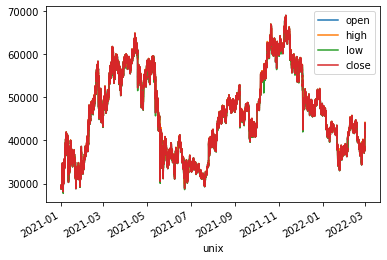

In [25]:
df.plot()

In [26]:
df.describe()

,open,high,low,close
count,610782.000000,610782.000000,610782.000000,610782.000000
mean,46482.265381,46509.783597,46454.085712,46482.567211
std,9453.990285,9454.798088,9453.135638,9454.107853
min,28093.810000,28397.520000,27734.000000,28073.030000
25%,38129.052500,38157.882500,38099.437500,38129.137500
50%,46666.960000,46697.745000,46636.710000,46667.295000
75%,54907.797500,54938.655000,54877.405000,54907.412500
max,69000.000000,69000.000000,68799.990000,69000.000000


# Get Y Value and resample to 5 min interval

In [27]:
df['y'] = df['close'].shift(-1)
df = df[:-1]
df = df.resample('5Min').asfreq().dropna()

In [28]:
first = df.index[0].timestamp()
last = df.index[-1].timestamp()

# Get ETH Data

In [29]:
df_eth = pd.read_csv('../data/ETHUSD_5.csv', header = None, names = ["unix", "open", "high", "low", "close", "volume", "trades"])
df_eth['unix'] = pd.to_datetime(df_eth['unix'], unit='s')
df_eth = df_eth.set_index(pd.DatetimeIndex(df_eth['unix']))
df_eth = df_eth.drop(df_eth[['volume', 'trades', 'unix']], axis=1)
df_eth.sort_values(by='unix', inplace=True)

# Join

In [30]:
df = df.join(df_eth, on='unix', how='inner', lsuffix='_btc', rsuffix='_eth')

# Generate Train Test split

In [31]:
from sklearn.model_selection import train_test_split
random_state = 42
train_size = 0.8
X = df[['open_btc', 'high_btc', 'low_btc', 'close_btc', 'open_eth', 'high_eth', 'low_eth', 'close_eth']]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size, random_state=random_state) 

# Configure MLFlow endpoint

In [33]:
import os
import mlflow

os.environ["AWS_ACCESS_KEY_ID"] = "mlflow"
os.environ["AWS_SECRET_ACCESS_KEY"] = "mlflow123"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://mlflow-minio.mlflow.svc.cluster.local:9000/"
model_artifact_name = "model"

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")
mlflow.set_experiment("bitcoin")

<Experiment: artifact_location='s3://mlflow/1', creation_time=None, experiment_id='1', last_update_time=None, lifecycle_stage='active', name='bitcoin', tags={}>

# Fit and export the model

In [36]:
import logging
import mlflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow.models.signature import infer_signature

np.random.seed(random_state)
tf.random.set_seed(random_state) 

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

if __name__ == "__main__":
    with mlflow.start_run():
        mlflow.tensorflow.autolog()
        
        model = Sequential()
        model.add(Dense(32, input_shape=(X_train.shape[-1],), activation="relu", name="hidden_layer"))
        model.add(Dense(16))
        model.add(Dense(1))
        model.compile(loss="mse", optimizer="adam")
        
        model.fit(X_train, y_train, epochs=5, batch_size=100, validation_split=.2)
               
        # Evaluate the best model with testing data.
        y_hat = model.predict(X_test)
        (rmse, mae, r2) = eval_metrics(y_test, y_hat)
        mlflow.log_param("data_from", first)
        mlflow.log_param("data_to", last)
        mlflow.log_param("feature_view", "crypto_stats")
        mlflow.log_param("framework", "tensorflow")
        mlflow.log_param("version", tf.__version__)
        mlflow.log_param("random_state", random_state)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        lr = res = {"lr_" + str(key): val for key, val in model.optimizer.get_config().items()}
        mlflow.log_params(lr)
        
        model_signature = infer_signature(X_train, y_train)
        info = mlflow.keras.log_model(model, model_artifact_name, registered_model_name="BitcoinForecast", signature=model_signature)
        
        uri = mlflow.get_artifact_uri()

Epoch 1/5
  1/780 [..............................] - ETA: 3:37 - loss: 7669894144.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0011s vs `on_train_batch_end` time: 0.0016s). Check your callbacks.


780/780 [==============================] - 2s 2ms/step - loss: 206574656.0000 - val_loss: 93068.0312
Epoch 2/5
780/780 [==============================] - 1s 2ms/step - loss: 53718.8164 - val_loss: 25320.8164
Epoch 3/5
780/780 [==============================] - 1s 1ms/step - loss: 12681.2617 - val_loss: 6082.8105
Epoch 4/5
780/780 [==============================] - 1s 1ms/step - loss: 4634.7124 - val_loss: 4152.1084
Epoch 5/5
780/780 [==============================] - 1s 1ms/step - loss: 4105.3643 - val_loss: 4141.6431
INFO:tensorflow:Assets written to: /tmp/tmpsf3axpr4/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpsf3axpr4/model/data/model/assets


762/762 [==============================] - 1s 763us/step


/home/pierre/miniconda3/envs/realtime-mlops/lib/python3.10/site-packages/mlflow/keras.py:405: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input.
  warnings.warn(


INFO:tensorflow:Assets written to: /tmp/tmp4mc32gso/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp4mc32gso/model/data/model/assets
Registered model 'BitcoinForecast' already exists. Creating a new version of this model...
2022/10/04 17:40:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: BitcoinForecast, version 4
Created version '4' of model 'BitcoinForecast'.


# Update the inferenseservice yaml

In [200]:
storage_uri = f"{uri}/{model_artifact_name}"

In [201]:
#https://github.com/ipython/ipython/issues/6701
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [202]:
%%writetemplate deployment/isvc.yaml

apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "bitcoin-forecast"
  namespace: default
  labels:
    networking.knative.dev/visibility: cluster-local
spec:
  predictor:
    serviceAccountName: sa-s3
    model:
      modelFormat:
        name: mlflow
      protocolVersion: v2
      storageUri: {storage_uri}

In [205]:
%%writetemplate ../feast-kserve-transform/deployment/isvc.yaml

apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "bitcoin-forecast"
  namespace: default
  labels:
    networking.knative.dev/visibility: cluster-local
spec:
  predictor:
    serviceAccountName: sa-s3
    model:
      modelFormat:
        name: mlflow
      protocolVersion: v2
      storageUri: {storage_uri}
  transformer:
    containers:
    - image: piepra/feast-transformer:1.2
      name: btc-transfomer
      command:
      - "python"
      - "app/app.py"
      args:
      - --feast_serving_url
      - feast-feature-server.feast.svc.cluster.local:80
      - --entity_ids
      - "BTC/USD"
      - --feature_refs
      - "crypto_stats:open"
      - "crypto_stats:high"
      - "crypto_stats:low"
      - "crypto_stats:close"
      - --protocol
      - v2

In [3]:
!curl -v -H "Content-Type: application/json" -d @./payload.json \
 http://bitcoin-forecast.default.svc.cluster.local/v2/models/bitcoin-forecast-basic/infer

*   Trying 10.96.114.89:80...
* Connected to bitcoin-forecast.default.svc.cluster.local (10.96.114.89) port 80 (#0)
> POST /v2/models/bitcoin-forecast-basic/infer HTTP/1.1
> Host: bitcoin-forecast.default.svc.cluster.local
> User-Agent: curl/7.81.0
> Accept: */*
> Content-Type: application/json
> Content-Length: 494
> 
^C
